In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Maximum Likelihood and Regression

This notebook explains exemplarily on a simple weather monitoring use case the concepts of maximum likelihood with respect to regressive models. We touch on the concepts of non-analytical parameter optimization, non-linear model regression such as neural networks and the utility of recurrent neural network architectures when it comes to time series prediction. 

* [1. Maximum Likelihood](#MaximumLikelihood)
* [2. Regression](#Regression)
 * [2.1 Linear and non-linear regression](#NeuralNetworks)
* [3. Long-Short Term Memory Networks](#LSTM)


Let us load some temperature data we recorded between 14:00-15:00 and plot a Histogram

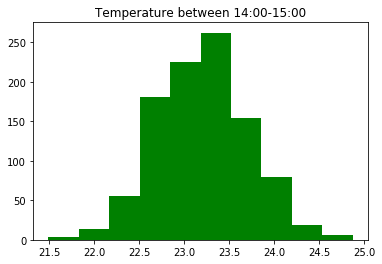

In [2]:
temp_afternoon = np.load("data/temperature_constant.npy")

fig, ax = plt.subplots()
ax.set_title("Temperature between 14:00-15:00")
n, bins, patches = ax.hist(temp_afternoon, facecolor='green')



**Typical Questions**:
 * *How is the temperature distributed?*

 * *What can I be expected to measure next with what probabilities?*

**Assumption**:

Data is distributed according to a Gaussian distribution (There is some motivation for this):

$$T_i\sim p(y\ |\ \mu,\sigma)=\frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{\left(y-\mu\right)^2}{2\sigma^2}\right)$$

The Gaussian distribution has *two* free parameters, $\mu$ and $\sigma$ that have to be determined somehow

## Maximum Likelihood<a name="MaximumLikelihood"></a>
Probability density for each datapoint that this could have been measured given that the model is true.

* Measure $N$ times and collect the dataset: $\mathbf{Y}=\{T_i, i=1\ldots N\}$
* Each observation is independent from all other observations
* All observations are assumed to originate from the same mechanism
* (independetly, identically distributed, i.i.d) $\rightarrow$The total probability density is the product of each individual observation:
$$p(Y\ |\ \theta)=\prod_{i=1}^N p(T_i\ |\ \mu,\sigma)$$
Where $\theta$ is the set of free parameter, in this case $\theta=\{\mu, \sigma^2\}$

Maximum Likelihood just maximizes this number with respect to $\theta$ and in general, there are a lot of ways this can be done. This is part of optimization. For simpler mathematics and reasons of numerical stability, one minimizes the negative log-likelihood instead of the likelihood function (also *Loss* or *Error*-function):
$$L(\theta\ |\ \mathbf Y)=-2\log\left(p(Y\ |\ \theta)\right)=\frac{1}{\sigma^2}\sum_{i=1}^N\left\|T_i-\mu\right\|^2 + N\log(2\pi\sigma^2)$$

Maximum Likelihood is then:

$$\theta^*=\underset{\theta}{\mathrm{argmax}}\left(P(Y\ |\ \theta)\right)=\underset{\theta}{\mathrm{argmin}}\left(L(\theta\ |\ \mathbf Y)\right)$$

In this case we can optimize analytically, by taking the derivatives with respect to $\mu$ and $\sigma^2$ which will give us the empirical mean and variance of the distribution (Who would have thought?):

$$0=\frac{\partial L}{\partial \mu}\Leftrightarrow \mu=\frac{1}{N}\sum_{i=1}^N T_i\equiv\bar T$$
$$0=\frac{\partial L}{\partial \sigma^2}\Leftrightarrow \sigma^2=\frac{1}{N}\sum_{i=1}^N (T_i-\bar T)^2$$

We can now visually inspect the results:

Mean=23.20°C, Std=0.51°C, [Ground truth generated: 23.2, 0.5]


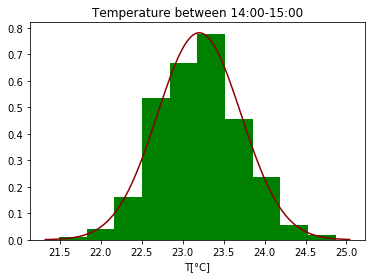

In [3]:
temperature_mean = temp_afternoon.mean()
temperature_std = temp_afternoon.std()
from scipy.stats import norm

fig, ax = plt.subplots()
ax.set_title("Temperature between 14:00-15:00")
ax.set_xlabel("T[°C]")
n, bins, patches = ax.hist(temp_afternoon, facecolor='green', density=True)

t_scale = np.linspace(ax.axis()[0], ax.axis()[1], 100)
ax.plot(t_scale, norm.pdf(t_scale, temperature_mean, temperature_std), color="darkred")

print("Mean={0:#.4g}°C, Std={1:#.2g}°C, [Ground truth generated: 23.2, 0.5]".format(temperature_mean, temperature_std))

## Regression

We now install a temperature sensor and record for three days:

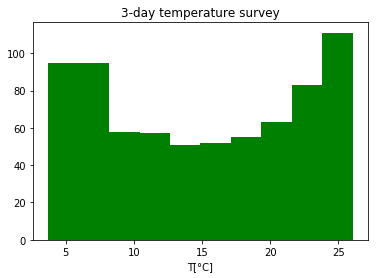

In [4]:
df = pd.read_csv("data/temperature_day.csv")

fig, ax = plt.subplots()
ax.set_title("3-day temperature survey")
ax.set_xlabel("T[°C]")
n, bins, patches = ax.hist(df.temperature, facecolor='green', density=False)

Hmmm... This is not good, it doesn't look gaussian at all, the temperature changed all over the place during the day-night-cycle.

[//]: # (We could maybe fit a uniform distribution, but this is not really what we want, because it is very uninformative: We will only be able to answer questions regarding the day as a whole, but not with regards to specific times and weather conditions.)


There is bad news and good news:
1. The bad; unfortunately, we forgot to record the time of day the temperature was measured.
2. However, our sensor also recorded the light intensity, so we could use that to infer some additional information.

Lets do a scatter-plot...

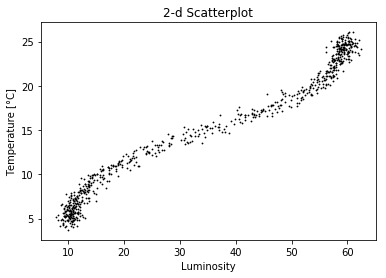

In [5]:
fig, ax = plt.subplots()
ax.set_title("2-d Scatterplot")
ax.set_xlabel("Luminosity")
ax.set_ylabel("Temperature [°C]")

_ = ax.plot(df.luminosity, df.temperature, 'o', ms=0.8, color="black")


We notice two things:
1. A clear functional dependecy is visible
2. Beside this dependency, there still is the kind of "noise" we have seen before when we just recorded for one hour

**Idea:**
Model the gaussian parameter not as a constant, but instead as a function of the *independent* variable.
* Independent variable ($x$): Luminosity
* Dependent variable ($y$): Temperature
* Regression function: $f:x\mapsto(\mu,\sigma)$


Often, we have no reason to suspect that $\sigma$ should also depend on $x$, so we set it constant.
For $\mu$, we could do a linear regression, that would look like this:

$$\mu(x)=Ax+b$$

Because the dependency isn't really linear we might just add some more terms (polynomial regression)
$$\mu(x)=ax^3+bx^2+cx+d$$

Here, $\theta=\{a,b,c,d,\sigma\}$.

Can we still find $\theta^*$ analytically like before?

- Yes, because everything is linear ($\mu$ linear to $a,b,c,d$). We just have to take some more derivatives.

There will be a linear system of eqations that can be solved for $a,b,c,d$ and $\sigma^2=\frac{1}{N}\sum_{i=1}^N (y_i-\bar y)^2$ as before, with $\bar y = \frac{1}{N}\sum_{i=1}^N ax_i^3+bx_i^2+cx_i+d$

Just to see some numerical optimization at work, use scipy.optimize

In [6]:
from scipy.optimize import fmin

# number of terms in the polynomial
n_poly = 4

mu_function = lambda theta, x: np.sum(np.array([theta[i]*x**i for i in range(n_poly)]), axis=0)
loss_function = lambda theta, x, y: np.sum((y - mu_function(theta, x))**2)

theta_star = np.zeros(n_poly)
results = fmin(loss_function, theta_star, args=(df.luminosity.values, df.temperature.values), full_output=1)

theta_star = results[0]
print("theta*={0}".format(theta_star))

Optimization terminated successfully.
         Current function value: 692.849345
         Iterations: 230
         Function evaluations: 396
theta*=[ -1.30586224e+00   9.37019628e-01  -2.07691803e-02   2.03658979e-04]


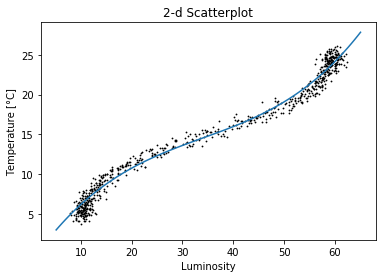

In [7]:
# Replot scatterplot
fig, ax = plt.subplots()
ax.set_title("2-d Scatterplot")
ax.set_xlabel("Luminosity")
ax.set_ylabel("Temperature [°C]")

_ = ax.plot(df.luminosity, df.temperature, 'o', ms=0.8, color="black")

l_scale = np.linspace(ax.axis()[0], ax.axis()[1], 100)
_ = ax.plot(l_scale, mu_function(theta_star, l_scale))

Now, we can also check our histogram and see if we can get a good fit with the Gaussian distribution

Mean=-0.044°C, Std=0.98°C, [Ground thruth generated: Std=0.5]


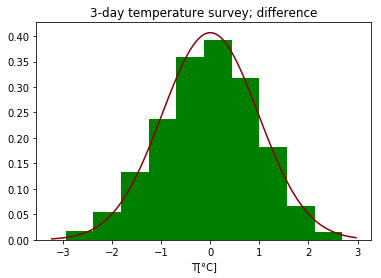

In [8]:
fig, ax = plt.subplots()
ax.set_title("3-day temperature survey; difference")
ax.set_xlabel("T[°C]")
temperature_difference = df.temperature.values - mu_function(theta_star, df.luminosity.values)
n, bins, patches = ax.hist(temperature_difference, facecolor='green', density=True)

temperature_mean = np.mean(temperature_difference)
temperature_std = np.sqrt(np.mean(temperature_difference**2))
t_scale = np.linspace(ax.axis()[0], ax.axis()[1], 100)
ax.plot(t_scale, norm.pdf(t_scale, 0, temperature_std), color="darkred")

print("Mean={0:#.2g}°C, Std={1:#.2g}°C, [Ground thruth generated: Std=0.5]".format(temperature_mean, temperature_std))

There is at least two reasons why we will have a hard time matching the true variance from the generative process in the model:
1. Our regression model inadequatily addresses the underlying process
2. Our independent variable (Luminosity) is itself an imperfect measurement $\rightarrow$ additional variance

### Linear and non-linear regression <a name="NeuralNetworks"></a>
**Neural Networks**

The first problem can sometimes be aleviated with the help of a neural network, because a neural network can theoretically approximate any function, and does so in practice much better than just adding more terms to a polynomial regression. Polynomial regression tends to go crazy between the data points very quickly if the number of free parameter gets larger (approaches the number of data points) where as neural networks have a easier time to "generalize"; Giving reasonable predictions even between data points.

A feed-forward neural network always alternates between linear transformation (affine transformations) and non-linearity given by some scalar (differentiable) function $g$:

$$f(x\ |\ \theta)= \ldots b^{(1)} + A^{(1)}g\left(b^{(0)} + A^{(0)}x\right)$$

Here, $\theta$ is the set of all free parameters of the affine transformations of all the layers.

Because $g$ is non-linear - unlike the polynomial case - it is not possible to optimize the parameter analytically. Instead, usually some kind of gradient descent algorithm is used in an iterative optimization process:

$$\theta_{i+1}=\theta_i - \gamma \frac{\partial L}{\partial\theta_i}$$

This is possible because the neural network function $f$ is differentiable (almost) everywhere.

## Long-Short Term Memory Neural Network<a name="LSTM"></a>

What if we don't want to predict the current temperature, but instead want to know the temperature at a later (or earlier) time? Lets take a look at the time-series:

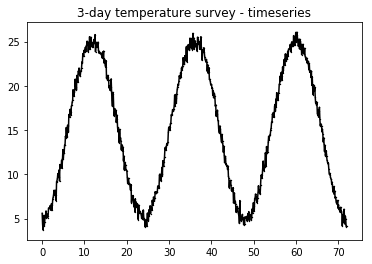

In [9]:
fig, ax = plt.subplots()
ax.set_title("3-day temperature survey - timeseries")

_ = ax.plot(df.hours, df.temperature, '-s', ms=0.4, color="black")

A regression would then look something like this:
* Possible Independent Variables: $T_i$, $L_i$
* Dependent Variable: $T_{i+d}$ with some number $d$.

Problem is that there is a falling and a rising flank, therefore the next point can not be predicted just given the previous datum. In general, there could be a lot more different kind of patterns and information from the past that is relevant to predict the future to the best of our knowledge.

**LSTM** (or any kind of recurrent neural network) just feeds forward some past information to the current iteration of  a prediction process that is recurrent in time (Start at the beginning, and go through the time-series). Therefore, the parametric function that models the Gauss-parameter looks like this:

$$(\mu_{i+d}, \sigma_{i+d}, s_{i+1}) = f(x_i, s_i)$$

Where $s_i$ is the current state